In [48]:
%matplotlib inline

In [49]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import numpy as np
from skimage import io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.utils as vutils

## Dataset and Data Loader

In [53]:
def show_batch(dl, limit=32):
    """Display a batch of images.
    
    Parameters
    -----------
    dl: DataLoader
    limit: int
        Max # of images to display (since we usually don't need to see all 128
        images in the batch).
    """
    batch = next(iter(dl))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.transpose(vutils.make_grid(batch[0][:32], normalize=True, 
                                             nrow=8), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [114]:
ngpu = 1
img_size = 64
input_c = 100
bs = 128

device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')
root = 'sketch_data/photo/tx_000100000000'

In [51]:
tfms = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

photo_ds = ImageFolder(root, transform=tfms)
photo_dl = DataLoader(photo_ds, batch_size=bs, shuffle=True)

In [23]:
batch = next(iter(photo_dl))
batch[0].shape, batch[1].shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [7]:
# For testing, try folder that contains: camel, giraffe, horse, zebra
root_small = root + '/tmp'
small_bs = 50

small_ds = ImageFolder(root_small, transform=tfms)
small_dl = DataLoader(small_ds, batch_size=small_bs, shuffle=True)

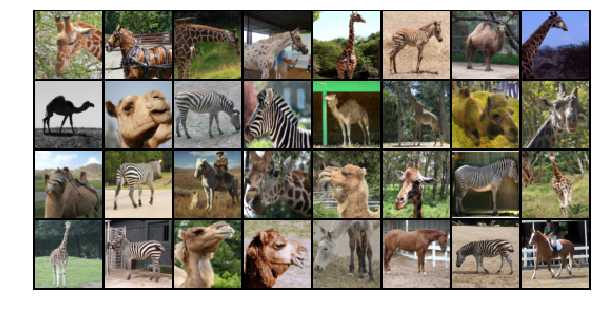

In [56]:
show_batch(small_dl)

## Models

In [8]:
def conv(strided, c_in, c_out, f, stride, pad, bias=False, bn=True):
    """Create deconv block consisting of a backward strided convolution 
    optionally followed by a batch norm layer.
    """
    if strided:
        conv_ = nn.ConvTranspose2d(c_in, c_out, f, stride, pad, bias=bias)
    else:
        conv_ = nn.Conv2d(c_in, c_out, f, stride, pad, bias=bias)
    conv_.weight.data.normal_(0.0, 0.02)
    layers = [conv_]
    if bn:
        bn_ = nn.BatchNorm2d(c_out)
        bn_.weight.data.normal_(1.0, 0.02)
        bn_.bias.data.zero_()
        layers.append(bn_)
    return nn.Sequential(*layers)

In [108]:
class Generator(nn.Module):
    
    def __init__(self, input_c=100, final_c=64):
        super().__init__()
        # 100 x 1 x 1 -> 512 x 4 x 4
        self.deconv1 = conv(True, input_c, final_c*8, f=4, stride=1, pad=0)
        # 512 x 4 x 4 -> 256 x 8 x 8
        self.deconv2 = conv(True, final_c*8, final_c*4, 4, 2, 1)
        # 256 x 8 x 8 -> 128 x 16 x 16
        self.deconv3 = conv(True, final_c*4, final_c*2, 4, 2, 1)
        # 128 x 16 x 16 -> 64 x 32 x 32
        self.deconv4 = conv(True, final_c*2, final_c, 4, 2, 1)
        # 64 x 32 x 32 -> 3 x 64 x 64
        self.deconv5 = conv(True, final_c, 3, 4, 2, 1, bn=False)
        
    def forward(self, x):
        x = F.relu(self.deconv1(x), True)
        x = F.relu(self.deconv2(x), True)
        x = F.relu(self.deconv3(x), True)
        x = F.relu(self.deconv4(x), True)
        x = torch.tanh(self.deconv5(x))
        return x

    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [133]:
class Discriminator(nn.Module):
    
    def __init__(self, dim_1=64, leak=.02):
        """
        Parameters
        -----------
        dim_1: int
            # of filters in first conv layer.
        leak: float
            Slope of leaky relu where x < 0.
        """
        super().__init__()
        self.leak = leak
        
        # 3 x 64 x 64 -> 64 x 32 x 32
        self.conv1 = conv(False, 3, dim_1, f=4, stride=2, pad=1, bn=False)
        # 64 x 32 x 32 -> 128 x 16 x 16
        self.conv2 = conv(False, dim_1, dim_1*2, 4, 2, 1)
        # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv3 = conv(False, dim_1*2, dim_1*4, 4, 2, 1)
        # 256 x 8 x 8 -> 512 x 4 x 4
        self.conv4 = conv(False, dim_1*4, dim_1*8, 4, 2, 1)
        # 512 x 4 x 4 -> 1 x 1 x 1
        self.conv5 = conv(False, dim_1*8, 1, 4, 1, 0, bn=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), self.leak, True)
        x = F.leaky_relu(self.conv2(x), self.leak, True)
        x = F.leaky_relu(self.conv3(x), self.leak, True)
        x = F.leaky_relu(self.conv4(x), self.leak, True)
        x = torch.sigmoid(self.conv5(x))
        return x.squeeze()
    
    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [106]:
g = Generator(input_c=100).to(device)

In [131]:
x_tmp = torch.randn(8, 100, 1, 1)
y_tmp = g(x_tmp)
y_tmp.shape

torch.Size([8, 3, 64, 64])

In [134]:
d = Discriminator().to(device)

In [135]:
d(y_tmp).shape

torch.Size([8])

## Training

In [138]:
def train(d, g, epochs, dl, lr=2e-4, b1=.5, b2=.999):
    """Train generator and discriminator with Adam.
    
    Parameters
    -----------
    D: nn.Module
        Discriminator
    G: nn.Module
        Generator (binary classifier, 1 for real, 0 for fake).
    dl: DataLoader
    lr: float
        Learning rate. Paper recommends .0002.
    beta1: float
        Hyperparameter for Adam. Paper recommends 0.5.
    """
    criterion = nn.BCELoss()
    d_optim = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, b2))
    g_optim = torch.optim.Adam(g.parameters(), lr=lr, betas=(b1, b2))
    fixed_noise = torch.randn(dl.batch_size, 100, 1, 1, device=device)
    
    # Store stats to return at end.
    d_real_losses = []
    d_fake_losses = []
    d_real_avg = []
    d_fake_avg = []
    g_losses = []
    samples = []
    
    # Train D and G.
    for epoch in range(epochs):
        d.train()
        g.train()
        for i, (x, y) in enumerate(dl):
            x = x.to(device)
            bs_curr = x.shape[0]
            real_labels = torch.ones(bs_curr, device=device)
            fake_labels = torch.zeros(bs_curr, device=device)
            noise = torch.randn(bs_curr, 100, 1, 1, device=device)
            
            ##################################################################
            # Train discriminator. Detach G output for speed.
            ##################################################################
            d_optim.zero_grad()
            fake = g(noise)
            y_hat_fake = d(fake.detach())
            y_hat_real = d(x)
            
            # Compute losses.
            d_loss_fake = criterion(y_hat_fake, fake_labels)
            d_loss_real = criterion(y_hat_real, real_labels)
            d_loss = d_loss_real + d_loss_fake
            
            # Update stats.
            fake_avg = y_hat_fake.mean().item()
            real_avg = y_hat_real.mean().item()
            d_fake_avg.append(fake_avg)
            d_real_avg.append(real_avg)
            d_fake_losses.append(d_loss_fake)
            d_real_losses.append(d_loss_real)
            
            # Backpropagation.
            d_loss.backward()
            d_optim.step()
            
            ##################################################################
            # Train generator. Use true_labels because we want to fool D.
            # G's weights are the same so no need to re-generate fake 
            # examples. D was updated so compute loss again. 
            ##################################################################
            g_optim.zero_grad()
            g_loss = criterion(d(fake), real_labels)
            g_losses.append(g_loss)
            g_loss.backward()
            g_optim.step()
        
        # Print losses.
        print(f'Epoch [{epoch+1}/{epochs}] \nBatch {i+1} Metrics:')
        print(f'D loss (real): {d_loss_real:.4f}\t', end='')
        print(f'D loss (fake): {d_loss_fake:.4f}')
        print(f'G loss: {g_loss:.4f}\n')
            
        # Save weights at end of epoch.
#         states = dict(g=g.state_dict(), 
#                       d=d.state_dict(),
#                       g_optimizer=g_optim.state_dict(),
#                       d_optimizer=d_optim.state_dict(),
#                       epoch=epoch)
#         torch.save(states, 'weights/model.pth')

        # Generate sample from fixed noise at end of epoch.
        with torch.no_grad():
            fake = g(fixed_noise).detach().cpu()
            samples.append(fake)
        
    return samples, dict(d_real_losses=d_real_losses, 
                         d_fake_losses=d_fake_losses,
                         g_losses=g_losses,
                         d_real_avg=d_real_avg,
                         d_fake_avg=d_fake_avg)

In [15]:
def plot_output(output):
    """Plot losses and average predictions by mini batch."""
    # Plot losses by epoch.
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax[0].plot(output['d_real_losses'], label='D real')
    ax[0].plot(output['d_fake_losses'], label='D fake')
    ax[0].plot(output['g_losses'], label='G')
    ax[0].set_title('Loss by Mini Batch')
    ax[0].legend()
    
    # Plot soft prediction average by epoch.
    ax[1].plot(output['d_real_avg'], label='Real examples')
    ax[1].plot(output['d_fake_avg'], label='Fake examples')
    ax[1].set_title('Average Soft Predictions (D) by Mini Batch')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [28]:
def plot_samples(samples, n=0):
    matplotlib.rcParams['animation.writer'] = 'html'
    fig = plt.figure(figsize=(9, 6))
    plt.axis('off')
    grids = [vutils.make_grid(sample, normalize=True, nrow=2)
             for sample in samples]
    plots = [[plt.imshow(np.transpose(grid, (1, 2, 0)), animated=True)] 
             for grid in grids]
    anim = animation.ArtistAnimation(fig, plots, blit=True)
#     HTML(data=anim.to_html5_video())
#     anim.save('samples/sample.gif', writer='avconv', fps=60)

    plt.imshow(np.transpose(grids[n], (1, 2, 0)))

In [38]:
samples, output = train(d, g, 150, small_dl)

Epoch [1/150] 
Batch 8 Metrics:
D loss (real): 0.6832	D loss (fake): 0.7129
G loss: 0.6807

Epoch [2/150] 
Batch 8 Metrics:
D loss (real): 0.6993	D loss (fake): 0.6818
G loss: 0.7127

Epoch [3/150] 
Batch 8 Metrics:
D loss (real): 0.6969	D loss (fake): 0.6784
G loss: 0.7089

Epoch [4/150] 
Batch 8 Metrics:
D loss (real): 0.7089	D loss (fake): 0.6939
G loss: 0.7091

Epoch [5/150] 
Batch 8 Metrics:
D loss (real): 0.7086	D loss (fake): 0.6768
G loss: 0.7126

Epoch [6/150] 
Batch 8 Metrics:
D loss (real): 0.7025	D loss (fake): 0.6843
G loss: 0.7052

Epoch [7/150] 
Batch 8 Metrics:
D loss (real): 0.7034	D loss (fake): 0.6877
G loss: 0.7045

Epoch [8/150] 
Batch 8 Metrics:
D loss (real): 0.7043	D loss (fake): 0.6790
G loss: 0.7102

Epoch [9/150] 
Batch 8 Metrics:
D loss (real): 0.6991	D loss (fake): 0.6775
G loss: 0.7118

Epoch [10/150] 
Batch 8 Metrics:
D loss (real): 0.6889	D loss (fake): 0.7166
G loss: 0.6747

Epoch [11/150] 
Batch 8 Metrics:
D loss (real): 0.6884	D loss (fake): 0.6846
G 

Epoch [90/150] 
Batch 8 Metrics:
D loss (real): 0.6827	D loss (fake): 0.7040
G loss: 0.6850

Epoch [91/150] 
Batch 8 Metrics:
D loss (real): 0.6930	D loss (fake): 0.6991
G loss: 0.6905

Epoch [92/150] 
Batch 8 Metrics:
D loss (real): 0.6970	D loss (fake): 0.6942
G loss: 0.6924

Epoch [93/150] 
Batch 8 Metrics:
D loss (real): 0.7091	D loss (fake): 0.7018
G loss: 0.6828

Epoch [94/150] 
Batch 8 Metrics:
D loss (real): 0.6870	D loss (fake): 0.7005
G loss: 0.6872

Epoch [95/150] 
Batch 8 Metrics:
D loss (real): 0.6971	D loss (fake): 0.6934
G loss: 0.6963

Epoch [96/150] 
Batch 8 Metrics:
D loss (real): 0.6935	D loss (fake): 0.6979
G loss: 0.6913

Epoch [97/150] 
Batch 8 Metrics:
D loss (real): 0.6989	D loss (fake): 0.6921
G loss: 0.6981

Epoch [98/150] 
Batch 8 Metrics:
D loss (real): 0.7027	D loss (fake): 0.6902
G loss: 0.6961

Epoch [99/150] 
Batch 8 Metrics:
D loss (real): 0.6977	D loss (fake): 0.6899
G loss: 0.6964

Epoch [100/150] 
Batch 8 Metrics:
D loss (real): 0.6998	D loss (fake):

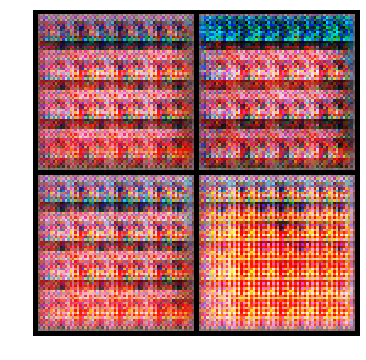

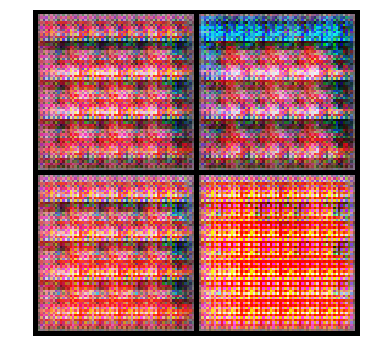

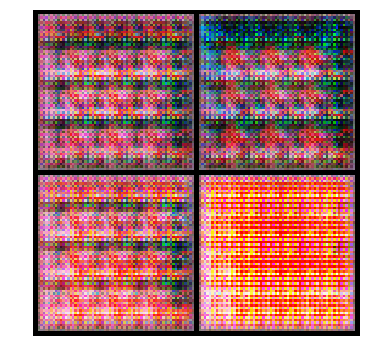

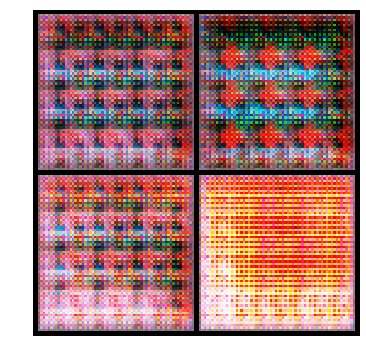

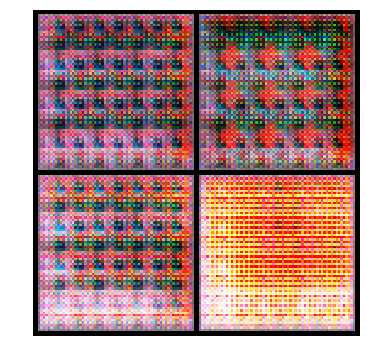

In [40]:
for i in range(5):
    plot_samples(samples, n=i)

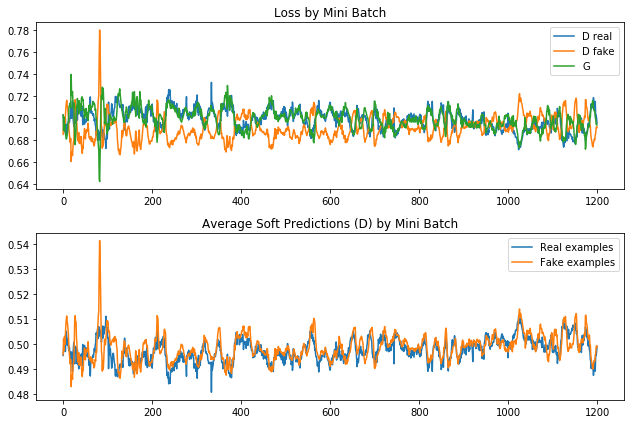

In [39]:
plot_output(output)